In [1]:
import os

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

from Model import GRU

### 1. Geo Analysis

In [2]:
df_shp = gpd.read_file("../data/geoshape/cb_2018_us_cbsa_20m/cb_2018_us_cbsa_20m.shp")
df_tweet_geo = pd.read_pickle("../data/twitter/TweetsGeoCount.pkl", compression="gzip")
df_sim_geo = pd.read_pickle("../simulation/SimulationGeo.pkl", compression="gzip")
df_hourly_geo = pd.read_pickle("../data/google_trend/DerailmentHourlyGeo.pkl", compression="gzip")
df_daily_geo = pd.read_pickle("../data/google_trend/DerailmentDailyGeo.pkl", compression="gzip")
df_search_us = pd.read_csv("../data/google_trend/DerailmentUS.csv", index_col="Date")
df_search_us.index = df_search_us.index.astype(str)
df_search_us /= 100

In [3]:
def plot(gdf: gpd.GeoDataFrame, axes, columns, xlim=(-125, -65), ylim=(25, 50)):
    for col, ax in zip(columns, axes.flatten()):
        scheme = None if len(gdf[col].unique()) < 5 else "fisher_jenks"
        gdf.plot(column=col, cmap="Reds", linewidth=0.1, edgecolor="white", scheme=scheme, ax=ax)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_title(col)

def make_video(df: pd.DataFrame, col: str, video_path: str, fps: int):
    frames = list()

    for dt in df[col].drop_duplicates():
        gdf = df[df[col]==dt]
        fig, axes = plt.subplots(2, 2, figsize=(15, 7.5))
        columns = ["Pollution", "Max Pollution", "Search", "Tweets"]
        plot(gdf, axes, columns)
        fig.suptitle(dt, fontsize=20)

        path = f"../simulation/temp.png"
        plt.savefig(path, dpi=450)
        plt.close(fig)
        frames.append(cv2.imread(path))
        os.remove(path)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(video_path, fourcc, fps, (frames[0].shape[1], frames[0].shape[0]))
    for frame in frames:
        writer.write(frame)
    writer.release()

#### 1.1 Hourly Simulation

In [4]:
df_hourly = list()
for dt in df_sim_geo["EST"].drop_duplicates():
    gdf = df_shp.set_index(["GEOID"])
    gdf["Pollution"] = df_sim_geo[df_sim_geo["EST"]==dt].groupby(["GEOID"])["P"].sum()
    gdf["Max Pollution"] = gdf["Pollution"] = gdf["Pollution"].fillna(0)
    gdf["Tweets"] = df_tweet_geo[df_tweet_geo["Hour"]==dt].groupby(["GEOID"])["Count"].sum()
    gdf["Tweets"] = gdf["Tweets"].fillna(0)
    gdf["Search"] = df_hourly_geo[df_hourly_geo["EST"]==dt].groupby(["GEOID"])["Count"].mean()
    gdf["EST"] = dt
    if df_hourly:
        gdf["Max Pollution"] = gdf["Max Pollution"].where(gdf["Max Pollution"] > df_hourly[-1]["Max Pollution"], df_hourly[-1]["Max Pollution"])
    df_hourly.append(gdf)
df_hourly = pd.concat(df_hourly)

In [41]:
frames[0].shape

(2250, 4500, 3)

In [53]:
df = df_hourly
col = "EST"
video_path = "../simulation/HourlySimulation.mp4"
fps = 16
frames = list()
plt.rcParams.update({'font.size': 12})

for dt in df[col].drop_duplicates():
    gdf = df[df[col]==dt].rename(columns={"Search": "Google Trend Attention",
                                          "Pollution": "Simulated Hazard Gases Dispersion"})
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    columns = ["Google Trend Attention", "Simulated Hazard Gases Dispersion"]
    plot(gdf, axes, columns)
    fig.suptitle(f"Geographic Distribution on {dt}", fontsize=20)
    path = f"../simulation/temp.png"
    fig.tight_layout(pad=1)
    plt.savefig(path, dpi=450)
    plt.close(fig)
    frames.append(cv2.imread(path))
    os.remove(path)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(video_path, fourcc, fps, (frames[0].shape[1], frames[0].shape[0]))
for frame in frames:
    writer.write(frame)
writer.release()

In [ ]:
make_video(df_hourly, "EST", "../simulation/HourlySimulation.mp4", 16)

#### 1.2 Daily Simulation

In [ ]:
df_daily = list()
for date in df_search_us.index:
    gdf = df_shp.set_index(["GEOID"])
    gdf["Search"] = df_daily_geo[df_daily_geo["Date"]==date].groupby(["GEOID"])["Count"].mean()
    gdf["Tweets"] = df_tweet_geo[df_tweet_geo["Date"]==date].groupby(["GEOID"])["Count"].mean()
    dt = pd.to_datetime(date) + pd.Timedelta(22, "hour")
    dt = min(dt, pd.Timestamp(df_hourly["EST"].max())).strftime("%Y-%m-%d %H:%M:%S")
    gdf["Pollution"] = df_hourly[df_hourly["EST"]==dt]["Pollution"]
    gdf["Max Pollution"] = df_hourly[df_hourly["EST"]==dt]["Max Pollution"]
    gdf["Date"] = date
    df_daily.append(gdf)

df_daily = pd.concat(df_daily)

In [ ]:
make_video(df_daily, "Date", "../simulation/DailySimulation.mp4", 2)

#### 1.3 R-score analysis

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
for i, (gdf, col) in enumerate([(df_hourly, "EST"), (df_daily, "Date")]):
    r2 = list()
    for dt in gdf[col].drop_duplicates():
        df = gdf[gdf[col]==dt]
        if df.empty:
            r2.append([dt, 0, 0])
        else:
            X = df[["Pollution", "Max Pollution"]]
            r2.append([dt,
                       Ridge(alpha=1e-3).fit(X, df["Search"]).score(X, df["Search"]),
                       Ridge(alpha=1e-3).fit(X, df["Tweets"]).score(X, df["Tweets"])])
    df_r2 = pd.DataFrame(r2, columns=[col, "R2 for Google Trend", "R2 for Tweets Count"]).set_index([col])
    df_r2.index = pd.DatetimeIndex(df_r2.index)
    df_r2.plot(figsize=(15, 5), grid=True, ax=axes[i])

### 2. Time Series Analysis 

In [68]:
df_search_us = pd.read_csv("../data/google_trend/DerailmentUS.csv", index_col="Date")
df_tweets = pd.read_csv("../data/twitter/DerailmentFeatures.csv", index_col="Date", sep="\t")
df_tiktok = pd.read_csv("../data/tiktok/DerailmentFeatures.csv", index_col="Date", sep="\t")
df_tiktok.loc["2023-02-03"] = [pd.NA, pd.NA, pd.NA]
df_search_us /= 100
df_search_us.index = pd.DatetimeIndex(df_search_us.index.astype(str))
df_tweets.index = pd.DatetimeIndex(df_tweets.index)
df_tiktok.index = pd.DatetimeIndex(df_tiktok.index)
df_tiktok = df_tiktok.sort_index().fillna(0)

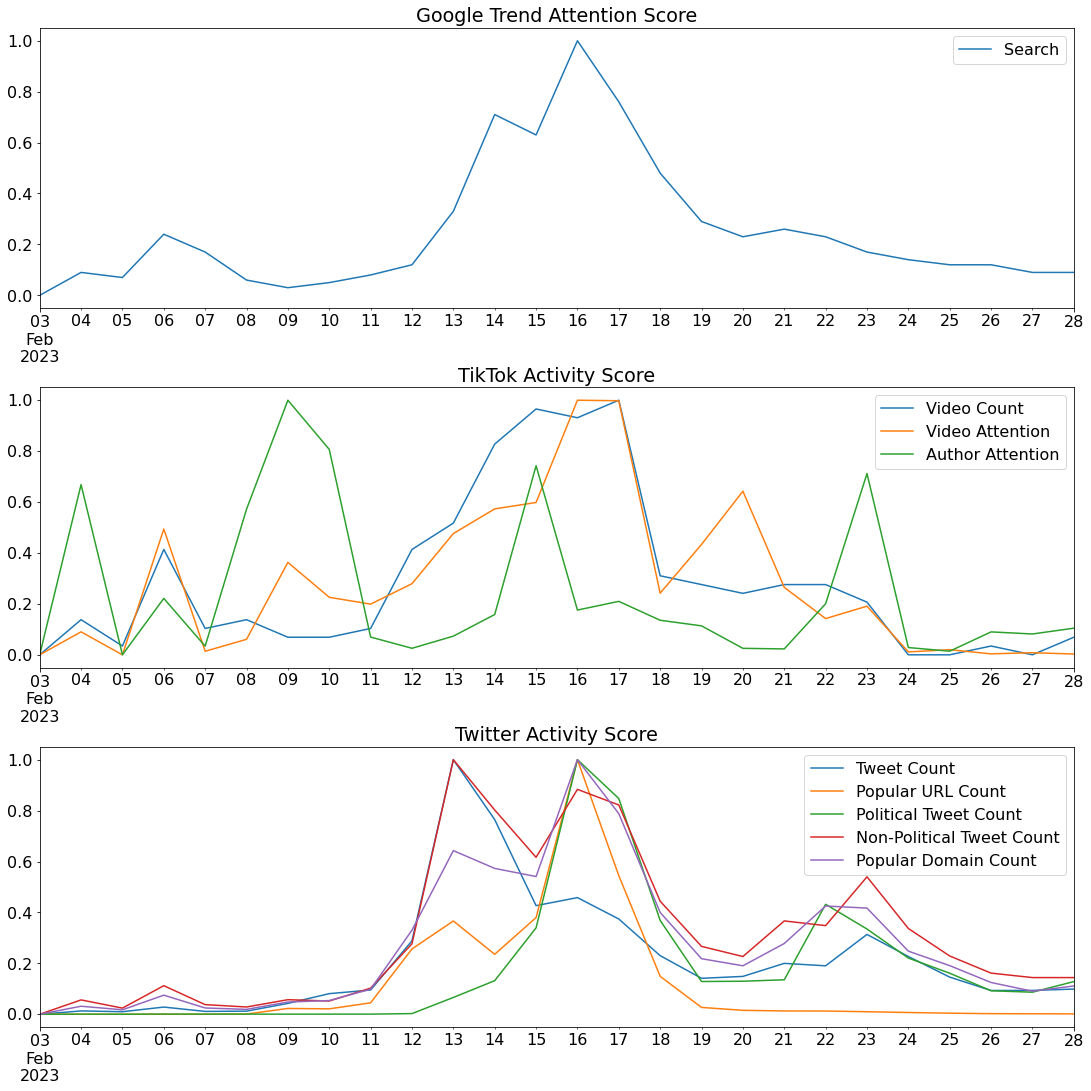

In [69]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
df_search_us.plot(ax=axes[0])
axes[0].set_title("Google Trend Attention Score")
axes[0].set_xlabel("")
# axes[0].set_ylabel("Attention Score")
df_tweets.plot(ax=axes[2])
axes[2].set_title("Twitter Activity Score")
axes[2].set_xlabel("")
# axes[1].set_ylabel("Activity Score")
df_tiktok.plot(ax=axes[1])
axes[1].set_title("TikTok Activity Score")
axes[1].set_xlabel("")
# axes[2].set_ylabel("Activity Score")
fig.tight_layout(pad=0.1)
plt.show()

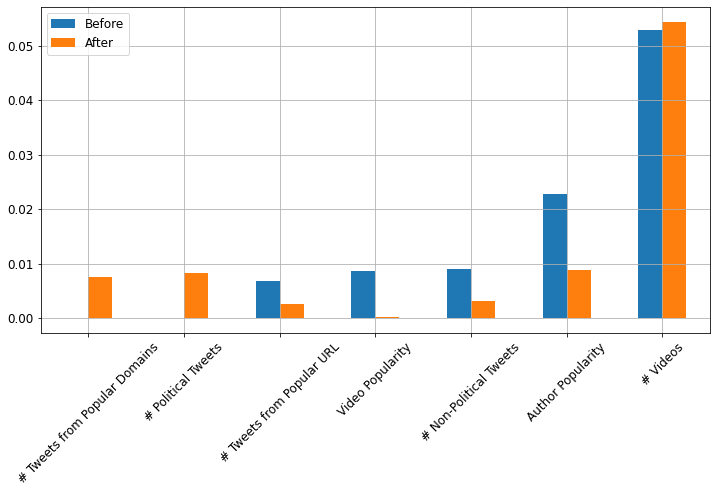

In [70]:
df_features = pd.concat([df_tweets, df_tiktok], axis=1).fillna(0)
y_before = df_search_us["Search"][:"20230211"]
X_before = df_features[:"20230211"]
y_after = df_search_us["Search"]["20230212":]
X_after = df_features["20230212":]

df_r2 = pd.DataFrame(columns=["Before", "After"], index=X_before.columns)
for i, (y, X) in enumerate([(y_before, X_before), (y_after, X_after)]):
    total_r2 = Ridge(alpha=1e-3).fit(X, y).score(X, y)
    feature_r2 = list()
    for feature_name in X_before.columns:
        features = X.drop(feature_name, axis=1)
        feature_r2.append(
            total_r2 - Ridge(alpha=1e-3).fit(features, y).score(features, y)
        )
    df_r2["Before" if i == 0 else "After"] = feature_r2
    
df_r2.index = [
    "# Tweets",
    "# Tweets from Popular URL",
    "# Political Tweets",
    "# Non-Political Tweets",
    "# Tweets from Popular Domains",
    "# Videos",
    "Video Popularity",
    "Author Popularity",
]
plt.rcParams.update({'font.size': 12})
df_r2[df_r2.index!="# Tweets"].sort_values(["Before"], ascending=True).plot(kind="bar", figsize=(12, 6), grid=True)
plt.xticks(rotation=45)
plt.show()

In [76]:
model = GRU(6, 50, 2)
feature_cols = ["Tweet Count", "Popular Domain Count", "Popular URL Count", "Video Count", "Video Attention", "Author Attention"]
X = pd.concat([df_tweets, df_tiktok], axis=1).fillna(0)[feature_cols].values
y = df_search_us["Search"].values
model.train(X, y, 50, 1e-2)

### 3. Nuclear Leak Analysis

#### 3.1 Feature Analysis

In [77]:
df_search_us = pd.read_csv("../data/google_trend/NuclearUS.csv", index_col="Date")
df_tweets = pd.read_csv("../data/twitter/NuclearFeatures.csv", index_col="Date", sep="\t")
df_tiktok = pd.read_csv("../data/tiktok/NuclearFeatures.csv", index_col="Date", sep="\t")
df_search_us /= 100
df_search_us.index = pd.DatetimeIndex(df_search_us.index.astype(str))
df_tweets.index = pd.DatetimeIndex(df_tweets.index)
df_tiktok.index = pd.DatetimeIndex(df_tiktok.index)

<AxesSubplot: xlabel='Date'>

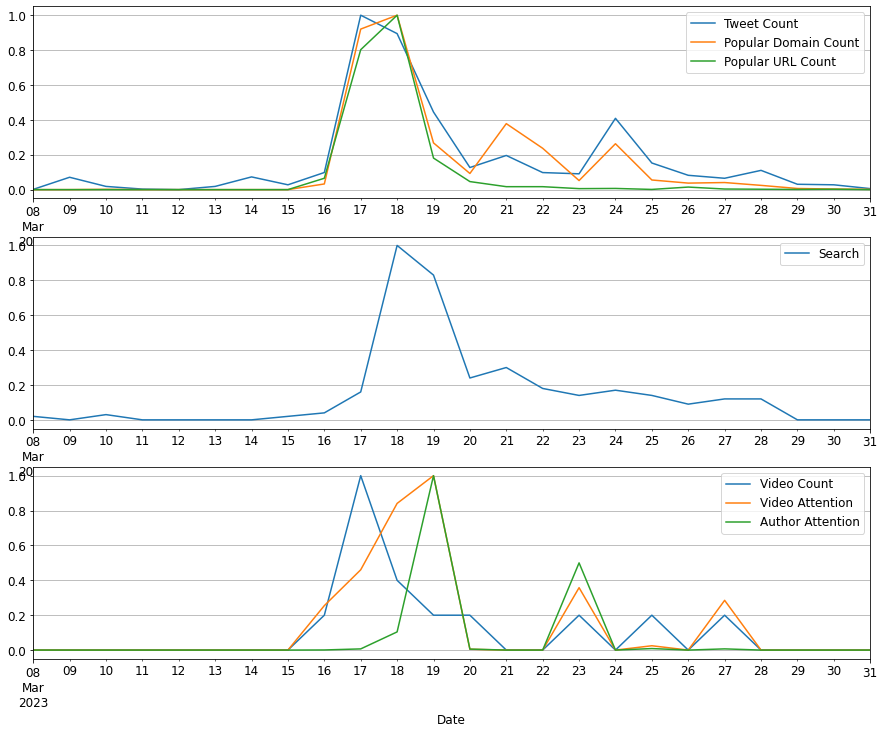

In [78]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
df_tweets.plot(figsize=(15, 12), grid=True, ax=axes[0])
df_search_us.plot(figsize=(15, 12), grid=True, ax=axes[1])
df_tiktok.plot(figsize=(15, 12), grid=True, ax=axes[2])

#### 3.2 Model Performance

0.007821974418357342

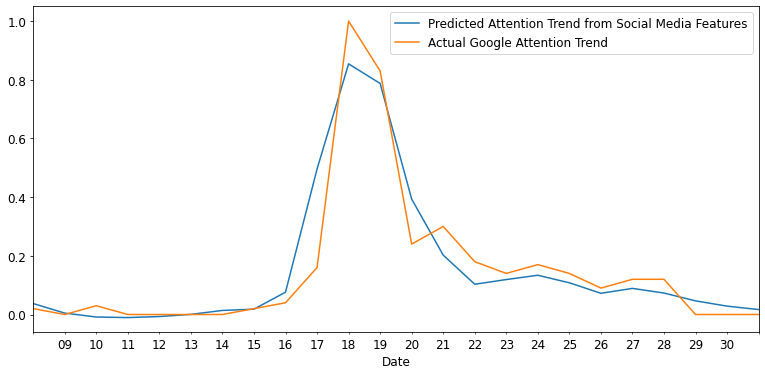

In [93]:
X = pd.concat([df_tweets, df_tiktok], axis=1).fillna(0)[feature_cols].values
y = df_search_us["Search"].values
y_pred = model.predict(X)
pd.DataFrame({"Predicted Attention Trend from Social Media Features": y_pred, "Actual Google Attention Trend": y}, index=df_tweets.index).plot(figsize=(13, 6))
plt.rcParams.update({'font.size': 12})
# plt.title("Prediction of Google Trend in Minnesotta Nuclear leak by social meadia features")
# plt.xlabel("Date")
# plt.ylabel("Attention Level")
plt.xticks([])
mean_squared_error(y, y_pred)

### 4. Generate Plots

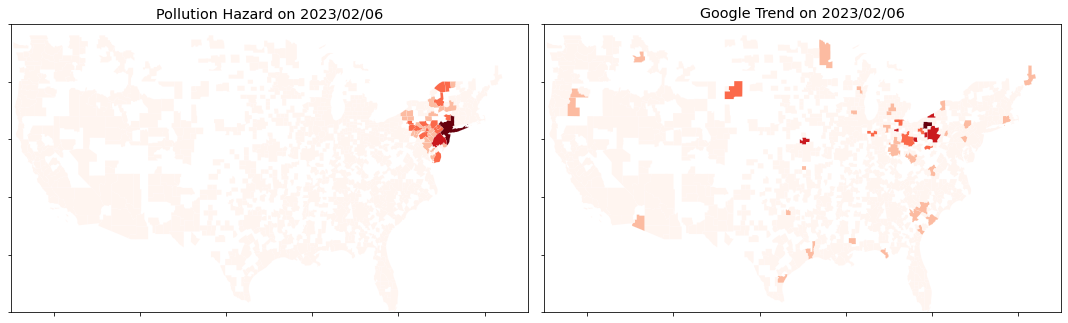

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
gdf = df_daily[df_daily["Date"]=="20230206"]
columns = ["Pollution", "Max Pollution", "Search", "Tweets"]
columns = ["Pollution Hazard", "Search Trend"]
plot(gdf.rename(columns={"Pollution": "Pollution Hazard", "Search": "Search Trend"}), axes, columns)
axes[0].set_title("Pollution Hazard on 2023/02/06")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_title("Google Trend on 2023/02/06")
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
fig.tight_layout()
plt.show()

NameError: name 'df_r2' is not defined

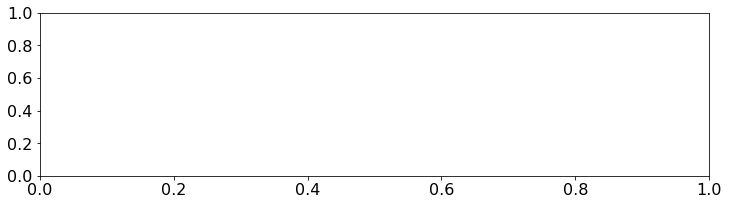

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(12, 3))
df_r2["R2 for Google Trend"][:"2023-02-11"].plot(ax=axes)
# axes.set_title("Daily R-sqaure between Google Trend and Simulated Hazard Level")
axes.set_xticklabels([])